## Which opponent is the most difficult to score points against?

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from scipy.stats import boxcox, zscore, zscore, norm, gaussian_kde

In [15]:
# Current gameweek 
gameweek = 12

## Collect available player data

In [16]:
# Initialize an empty list to store all individual, player gameweek data 
all_player_sep = []

# Loop through each gameweek
for i in range(1, gameweek + 1):  # Adjusting the range to start from 1 to gameweek
    # Read the CSV for the current gameweek
    x = pd.read_csv(rf'C:\Users\thoma\Code\Projects\Fantasy-Premier-League\Data\Players\Seperate_GW\GW_{i}.csv')
    
    # Append the current gameweek data to the list
    all_player_sep.append(x)

# Concatenate all dataframes in the list into a single dataframe
player_data = pd.concat(all_player_sep, axis=0, ignore_index=True)

# Drop unnamed column
player_data = player_data.drop(columns = ['Unnamed: 0'])

# Remove players who play less than 61 minutes in a game (i.e. they do not recieve their 2 points minimum for playoing this amount)
player_data = player_data[player_data['Minutes'] > 60].copy()

## Frequency Table

In [17]:
# Calculate frequencies of GW Points for all opponents
overall_frequency = (
    player_data['GW Points']
    .value_counts()
    .sort_index()
    .reset_index(name='Total')
)
overall_frequency.rename(columns={'index': 'GW Points'}, inplace=True)

# Initialize an empty list to store frequencies for each opponent
opponent_frequencies = []

# Get unique opponents and sort alphabetically
opponents = sorted(player_data['Opponent'].unique())

# Calculate frequency for each opponent
for opponent in opponents:
    # Filter data for the current opponent
    opponent_data = player_data[player_data['Opponent'] == opponent]
    
    # Calculate frequency for the opponent
    opp_frequency = (
        opponent_data['GW Points']
        .value_counts()
        .sort_index()
        .reset_index(name=f'{opponent}')
    )

    opp_frequency.rename(columns={'index': 'GW Points'}, inplace=True)
    
    # Append to the list
    opponent_frequencies.append(opp_frequency)

# Merge all opponent frequencies into a single DataFrame
counted_data = overall_frequency[['GW Points']]

for freq_df in opponent_frequencies:
    counted_data = counted_data.merge(freq_df, on='GW Points', how='left')

# Fill NaN values with 0 and remove decimals
counted_data.fillna(0, inplace=True)
counted_data = counted_data.astype(int)

# Combine data and reorder columns to place team names in alphabetical order
final_data = overall_frequency.merge(counted_data, on='GW Points')

## Frequency Distribution (standardized z-scores)
#### Each position versus each club

In [18]:
# Filter and sort players by position and points
def filter_and_sort(data, positions, points_column='GW Points'):
    return data[data['Position'].isin(positions)].sort_values(by=points_column, ascending=False)

# Assign difficulty ratings based on z-scores using quartiles
def assign_difficulty(data, zscore_column='z_score', position_name=None):
    data['Difficulty'] = pd.qcut(data[zscore_column], q=4, labels=[5, 4, 3, 2])
    return data

# Process players by position
def process_players(data, positions, position_name):
    filtered = filter_and_sort(data, positions)
    filtered['z_score'] = zscore(filtered['GW Points'])
    z_scores_grouped = (
        filtered.groupby('Opponent')['z_score'].mean().round(2)
        .reset_index().rename(columns={'z_score': 'z_score'})
    )
    z_scores_grouped['Position'] = position_name
    z_scores_grouped = assign_difficulty(z_scores_grouped, position_name=position_name)
    return z_scores_grouped

# Process defensive and attacking players
goalkeepers = process_players(player_data, ['GK', 'DEF'], 'GK')
defenders = process_players(player_data, ['GK','DEF'], 'DEF')
midfielders = process_players(player_data, ['MID', 'FWD'], 'MID')
forwards = process_players(player_data, ['MID','FWD'], 'FWD')

In [19]:
# Combined difficulty to assign to player games
difficulty = pd.concat([goalkeepers, defenders, midfielders, forwards])

# Check value counts
difficulty['Position'].value_counts()

Position
GK     40
DEF    40
MID    40
FWD    40
Name: count, dtype: int64

In [20]:
# Export to csv
#difficulty.to_csv('Model_3_FD.csv')

In [21]:
defenders = defenders.sort_values(by = 'z_score', ascending= False)

# Visual graphs

C:\Users\thoma\AppData\Local\Temp\ipykernel_27000\2789951610.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('Difficulty')['Opponent'].apply(list)


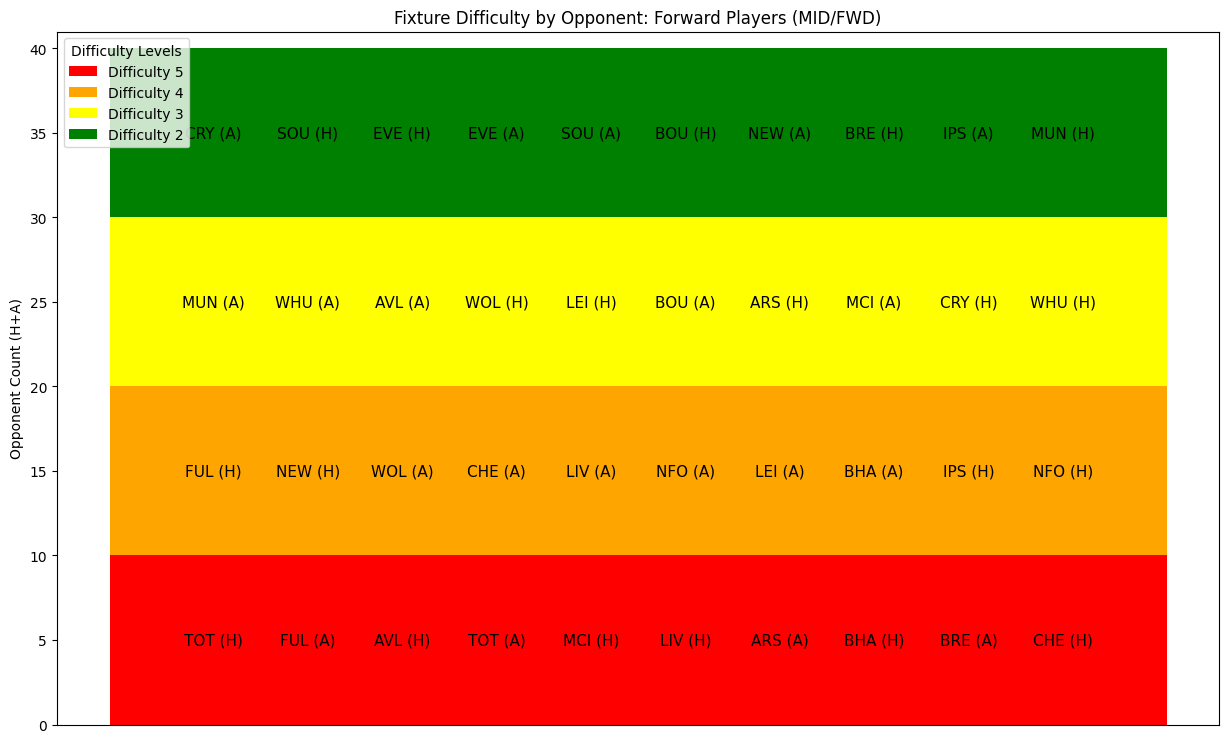

In [27]:
df = pd.DataFrame(defenders)

# Group by Difficulty
grouped = df.groupby('Difficulty')['Opponent'].apply(list)

# Define colors for each difficulty level
difficulty_colors = {
    5: 'red',
    4: 'orange',
    3: 'yellow',
    2: 'green',
}

# Create stacked bar chart
fig, ax = plt.subplots(figsize=(15, 9))
bottom = 0  # Keeps track of the cumulative height for stacking

for diff, opponents in grouped.items():
    # Number of opponents in this difficulty level
    bar_height = len(opponents)
    
    # Draw the stacked bar segment for this difficulty
    ax.bar(
        x=['Opponents'],  # Single stacked column
        height=[bar_height],  # Height is the count of opponents
        bottom=bottom,
        color=difficulty_colors[diff],
        label=f'Difficulty {diff}'
    )
    
    # Place opponent names distributed horizontally within this segment
    num_opponents = len(opponents) + 4
    for i, opponent in enumerate(opponents):
        # Calculate horizontal position
        x_pos = (i + 2.5) / num_opponents  # Normalized horizontal position within the bar
        ax.text(
            x=x_pos - 0.5,  # Offset from the bar center
            y=bottom + 5,  # Vertical position inside the bar
            s=opponent,
            ha='center',
            va='center',
            fontsize=11,
            color='black'
        )
    
    # Update the bottom position for the next segment
    bottom += bar_height

# Add labels and legend
plt.title('Fixture Difficulty by Opponent: Forward Players (MID/FWD)')
plt.ylabel('Opponent Count (H+A)')
plt.xticks(ticks=[], labels=[])  # No x-axis labels as there's only one bar
plt.legend(title="Difficulty Levels", loc = 'upper left')
plt.ylim(0, bottom + 1)
plt.show()